In [76]:
import os, sys, librosa
import pandas as pd
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd

import zipfile
from numba import jit

In [77]:
current_path = os.getcwd()
path_to_folder =os.path.join(current_path + "\coversongs\covers32k")

### Computing the similarity and accumulated score matrix

#### Basic similarity matrix

In [78]:
#@jit(nopython=True)
def compute_basic_similarity_matrix(X:np.array, Y:np.array):
    basic_sim = np.dot(X.T, Y)
    return basic_sim

#### Post-processing functions to enhance similarity matrix

In [79]:
#@jit(nopython=True)
def shift_cycl_matrix(S, shift):
    """Shifts the matrix similarity to make it correspond to shifted music signals
    in term of musical tonality. 
    Function taken from notebook by Meinard Müller

    Args:
        S (np.ndarray): similarity matrix
        shift (int): 
    Returns:
        shifted_matrix (np.ndarray): Shifted matrix
    """
    N, M = S.shape
    # Handle pooling of value at the matrix's limit
    shift = np.mod(shift, N)
    # Shift matrix 
    shifted_matrix = np.zeros((N, M))
    shifted_matrix[shift:N, :] = S[0:N-shift, :]
    shifted_matrix[0:shift, :] = S[N-shift:N, :]
    return shifted_matrix


#@jit(nopython=True)
def filter_diag_mult_sm(S, L=1, tempo_rel_set=np.asarray([1]), direction=0):
    """Path smoothing of similarity matrix by filtering in forward or backward direction
    along various directions around main diagonal.

    Args:
        S (np.ndarray): Self-similarity matrix (SSM)
        L (int): Length of filter (Default value = 1)
        tempo_rel_set (np.ndarray): Set of relative tempo values (Default value = np.asarray([1]))
        direction (int): Direction of smoothing (0: forward; 1: backward) (Default value = 0)

    Returns:
        S_L_final (np.ndarray): Smoothed SM
    """
    N = S.shape[0]
    M = S.shape[1]
    num = len(tempo_rel_set)
    S_L_final = np.zeros((N, M))

    for s in range(0, num):
        M_ceil = int(np.ceil(M / tempo_rel_set[s]))
        resample = np.multiply(np.divide(np.arange(1, M_ceil+1), M_ceil), M)
        np.around(resample, 0, resample)
        resample = resample - 1
        index_resample = np.maximum(resample, np.zeros(len(resample))).astype(np.int64)
        S_resample = S[:, index_resample]

        S_L = np.zeros((N, M_ceil))
        S_extend_L = np.zeros((N + L, M_ceil + L))

        # Forward direction
        if direction == 0:
            S_extend_L[0:N, 0:M_ceil] = S_resample
            for pos in range(0, L):
                S_L = S_L + S_extend_L[pos:(N + pos), pos:(M_ceil + pos)]

        # Backward direction
        if direction == 1:
            S_extend_L[L:(N+L), L:(M_ceil+L)] = S_resample
            for pos in range(0, L):
                S_L = S_L + S_extend_L[(L-pos):(N + L - pos), (L-pos):(M_ceil + L - pos)]

        S_L = S_L / L
        resample = np.multiply(np.divide(np.arange(1, M+1), M), M_ceil)
        np.around(resample, 0, resample)
        resample = resample - 1
        index_resample = np.maximum(resample, np.zeros(len(resample))).astype(np.int64)

        S_resample_inv = S_L[:, index_resample]
        S_L_final = np.maximum(S_L_final, S_resample_inv)

    return S_L_final


#@jit(nopython=True)
def apply_threshold_matrix(S, thresh, strategy='absolute', scale=False, penalty=0.0, binarize=False) :
    """Treshold matrix in a relative fashion

    Args:
        S (np.ndarray): Input matrix
        thresh (float or list): Treshold (meaning depends on strategy)
        strategy (str): Thresholding strategy ('absolute', 'relative', 'local') (Default value = 'absolute')
        scale (bool): If scale=True, then scaling of positive values to range [0,1] (Default value = False)
        penalty (float): Set values below treshold to value specified (Default value = 0.0)
        binarize (bool): Binarizes final matrix (positive: 1; otherwise: 0) (Default value = False)

    Returns:
        threshold_matrix (np.ndarray): Thresholded matrix
    """
    if np.min(S) < 0:
        raise Exception('All entries of the input matrix must be nonnegative')

    threshold_matrix = np.copy(S)
    N, M = S.shape
    num_cells = N * M

    if strategy == 'absolute':
        thresh_abs = thresh
        threshold_matrix[threshold_matrix < thresh] = 0

    if strategy == 'relative':
        thresh_rel = thresh
        num_cells_below_thresh = int(np.round(threshold_matrix.size*(1-thresh_rel)))
        if num_cells_below_thresh < num_cells:
            values_sorted = np.sort(threshold_matrix.flatten('F'))
            thresh_abs = values_sorted[num_cells_below_thresh]
            threshold_matrix[threshold_matrix < thresh_abs] = 0
        else:
            threshold_matrix = np.zeros([N, M])

    if strategy == 'local':
        thresh_rel_row = thresh[0]
        thresh_rel_col = thresh[1]
        S_binary_row = np.zeros([N, M])
        num_cells_row_below_thresh = int(np.round(M * (1-thresh_rel_row)))
        for n in range(N):
            row = S[n, :]
            values_sorted = np.sort(row)
            if num_cells_row_below_thresh < M:
                thresh_abs = values_sorted[num_cells_row_below_thresh]
                S_binary_row[n, :] = (row >= thresh_abs)
        S_binary_col = np.zeros([N, M])
        num_cells_col_below_thresh = int(np.round(N * (1-thresh_rel_col)))
        for m in range(M):
            col = S[:, m]
            values_sorted = np.sort(col)
            if num_cells_col_below_thresh < N:
                thresh_abs = values_sorted[num_cells_col_below_thresh]
                S_binary_col[:, m] = (col >= thresh_abs)
        threshold_matrix = S * S_binary_row * S_binary_col

    if scale:
        cell_val_zero = np.where(threshold_matrix == 0)
        cell_val_pos = np.where(threshold_matrix > 0)
        if len(cell_val_pos[0]) == 0:
            min_value = 0
        else:
            min_value = np.min(threshold_matrix[cell_val_pos])
        max_value = np.max(threshold_matrix)
        # print('min_value = ', min_value, ', max_value = ', max_value)
        if max_value > min_value:
            threshold_matrix = np.divide((threshold_matrix - min_value), (max_value - min_value))
            if len(cell_val_zero[0]) > 0:
                threshold_matrix[cell_val_zero] = penalty
        else:
            print('Condition max_value > min_value is voliated: output zero matrix')

    if binarize:
        threshold_matrix[threshold_matrix > 0] = 1
        threshold_matrix[threshold_matrix < 0] = 0
    return threshold_matrix




#### Main functions

In [80]:
#@jit(nopython=True)
def get_similarity_matrix(X, Y, L=1, tempo_rel_set=np.asarray([1]), shift_set=np.asarray([0]), direction=2):
    """Compute enhanced similarity matrix by applying path smoothing and transpositions
    Args:
        X (np.ndarray): First feature sequence
        Y (np.ndarray): Second feature sequence
        L (int): Length of filter (Default value = 1)
        tempo_rel_set (np.ndarray): Set of relative tempo values (Default value = np.asarray([1]))
        shift_set (np.ndarray): Set of shift indices (Default value = np.asarray([0]))
        direction (int): Direction of smoothing (0: forward; 1: backward; 2: both directions) (Default value = 2)

    Returns:
        S_TI (np.ndarray): Transposition-invariant SM
        I_TI (np.ndarray): Transposition index matrix
    """
    sim_matrix = np.zeros((len(X),len(Y)))
    # Compute similarity coefficient between each pair of coefficient
    for shift in shift_set:
        Y_cyc = shift_cycl_matrix(Y, shift)
        S_cyc = compute_basic_similarity_matrix(X, Y_cyc)

        if direction == 2:
            S_forward = filter_diag_mult_sm(S_cyc, L, tempo_rel_set=tempo_rel_set, direction=0)
            S_backward = filter_diag_mult_sm(S_cyc, L, tempo_rel_set=tempo_rel_set, direction=1)
            S_cyc = np.maximum(S_forward, S_backward)
        else : 
            S_cyc = filter_diag_mult_sm(S_cyc, L, tempo_rel_set, direction=direction)
        if shift == shift_set[0]:
            S_TI = S_cyc
            I_TI = np.ones((S_cyc.shape[0], S_cyc.shape[1])) * shift
        else:
            I_TI[S_cyc > S_TI] = shift
            S_TI = np.maximum(S_cyc, S_TI)

    return S_TI, I_TI
    
#@jit(nopython=True)
def compute_accumulated_score_matrix(sim_matrix : np.array):
    """ Compute the accumulated score matrix based on the similarity matrix.

    Args:
        sim_matrix (np.ndarray): Similarity matrix

    Returns:
         (np.ndarray): Accumulated score matrix
    """
    D = np.zeros((Sim_matrix.shape))

    D[0, 0] = max(0, S[0, 0])

    for n in range(1, N):
        D[n, 0] = max(0, D[n-1, 0] + S[n, 0])

    for m in range(1, M):
        D[0, m] = max(0, D[0, m-1] + S[0, m])

    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = max(0, D[n-1, m-1] + S[n, m], D[n-1, m] + S[n, m], D[n, m-1] + S[n, m])

    return D



### Comparing two versions of the same song : Little Wing (originally by Jimi Hendrix)

In [81]:
import pydub
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.signal import stft
import librosa

#### Vizualizing the two versions

In [ ]:
# First file : The Corrs' version
path_to_file_1 = os.path.join(path_to_folder, "Little_Wing\corrs+Talk_on_Corners_Special_Edition+12-Little_Wing.mp3")
audio = AudioSegment.from_file(path_to_file_1, format='mp3')
frame_rate = audio.frame_rate
print("Sample rate", audio.frame_rate)
print("Number of channels", audio.channels)


# convert to an array 
data_array = audio.get_array_of_samples()
audio_array_1 = np.array(data_array).T.astype(np.float32)
audio_array_1 /= np.iinfo(data_array.typecode).max

# Plot the audio segment
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.plot(np.arange(len(audio_array_1))/frame_rate, audio_array_1)
plt.xlabel("time (s)")
plt.ylabel("Amplitude")
plt.title("The Corrs - Little Wing")
plt.show()


x, sr = librosa.load(path_to_file_1)
ipd.Audio(x, rate=sr)

In [ ]:
# Second file : Eric Clapton's version

audio = AudioSegment.from_file(path_to_file_2, format='mp3')
frame_rate = audio.frame_rate
print("Sample rate", audio.frame_rate)
print("Number of channels", audio.channels)


# convert to an array 
data_array = audio.get_array_of_samples()
audio_array_2 = np.array(data_array).T.astype(np.float32)
audio_array_2 /= np.iinfo(data_array.typecode).max

# Plot the audio segment
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.plot(np.arange(len(audio_array_2))/frame_rate, audio_array_2)
plt.xlabel("time (s)")
plt.ylabel("Amplitude")
plt.title("Eric Clapton - Little Wing")
plt.show()

path_to_file_2 = os.path.join(path_to_folder, "Little_Wing\eric_clapton+Crossroads_2_Disc_1+08-Little_Wing.mp3")
x, sr = librosa.load(path_to_file_2)
ipd.Audio(x, rate=sr)

#### Extracting features

In [84]:
def compute_features(filename, chromagram, mfcc, tempogram):
    features = {}
    sound = pydub.AudioSegment.from_file(filename, format='mp3')
    rate = sound.frame_rate
    sound = np.array(sound.get_array_of_samples())
    sound = sound/np.max(sound)
    window_size = int(100*1e-3*rate)
    overlap = int(90*1e-3*rate)
    fftsize = 8192
    n_mfcc = 12
    gamma = 100
    if chromagram:
        features['chromagram'] = compute_chroma(sound, window_size, overlap, fftsize, rate, gamma)
    if mfcc:
        features['mfcc'] = compute_mfcc(sound, rate, n_mfcc, window_size, window_size-overlap)
    if tempogram:
        features['tempogram'] = compute_tempogram(sound, rate)
    return features

In [85]:
# Our main feature so we wanted to compute it by hand
def compute_chroma(sound, window_size, overlap, fftsize, rate, gamma):
    # STFT computation
    f, t, stft1 = stft(sound, fs=rate, window='hann', nperseg=window_size, noverlap=overlap)
    mag = np.abs(stft1)
    # We start by transforming the frequency axis into a 12-tone resolution axis corresponding to MIDI pitches
    f_borders = 2**((np.arange(129)-69-0.5)/12)*440
    stft_midi = np.zeros((128,mag.shape[1]))
    for i in range(128):
        f_indices = np.logical_and(f>=f_borders[i], f<=f_borders[i+1])
        stft_midi[i,:] = np.sum(mag[f_indices,:],axis=0)
    # Then we sum all notes from the same pitch class
    chromagram = np.zeros((12,mag.shape[1]))
    for i in range(12):
        chromagram[i,:] = np.sum(stft_midi[((np.arange(128)-i)% 12)==0,:], axis=0)
    chromagram_log = np.log(1 + gamma*chromagram)
    # plt.pcolormesh(t, np.arange(12), chromagram_log, cmap='cividis')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Frequency (kHz)')
    # plt.show()
    return chromagram_log

def compute_hpcp(sound):
    return

def compute_mfcc(sound, rate, n_mfcc, window_size, window_hop):
    mfcc = librosa.feature.mfcc(y=sound, sr=rate, n_mfcc=n_mfcc, norm='ortho', win_length=window_size, hop_length=window_hop)
    # librosa.display.specshow(mfcc, sr=rate, x_axis='time')
    # plt.title('MFCC')
    # plt.ylabel('DCT coeff')
    # plt.colorbar()
    return mfcc

def compute_tempogram(sound, rate):
    tempogram = librosa.feature.tempogram(y=sound, sr=rate)
    # librosa.display.specshow(tempogram, sr=rate, x_axis='time')
    # plt.ylim(80,200)
    # plt.ylabel('Beats (BPM)')
    # plt.colorbar()
    return tempogram

In [90]:
def quantize_matrix(C, quant_fct=None):
    """Quantize matrix values in a logarithmic manner (as done for CENS features)

    Notebook: C7/C7S2_CENS.ipynb

    Args:
        C (np.ndarray): Input matrix
        quant_fct (list): List specifying the quantization function (Default value = None)

    Returns:
        C_quant (np.ndarray): Output matrix
    """
    C_quant = np.empty_like(C)
    if quant_fct is None:
        quant_fct = [(0.0, 0.05, 0), (0.05, 0.1, 1), (0.1, 0.2, 2), (0.2, 0.4, 3), (0.4, 1, 4)]
    for min_val, max_val, target_val in quant_fct:
        mask = np.logical_and(min_val <= C, C < max_val)
        C_quant[mask] = target_val
    return C_quant

def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Notebook: C3/C3S1_FeatureNormalization.ipynb

    Args:
        X (np.ndarray): Feature sequence
        norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
        threshold (float): An threshold below which the vector ``v`` used instead of normalization
            (Default value = 0.0001)
        v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
            (Default value = None)

    Returns:
        X_norm (np.ndarray): Normalized feature sequence
    """
    assert norm in ['1', '2', 'max', 'z']

    K, N = X.shape
    X_norm = np.zeros((K, N))

    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'z':
        if v is None:
            v = np.zeros(K, dtype=np.float64)
        for n in range(N):
            mu = np.sum(X[:, n]) / K
            sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
            if sigma > threshold:
                X_norm[:, n] = (X[:, n] - mu) / sigma
            else:
                X_norm[:, n] = v

    return X_norm

def smooth_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10, w_type='boxcar'):
    """Smoothes and downsamples a feature sequence. Smoothing is achieved by convolution with a filter kernel

    Notebook: C3/C3S1_FeatureSmoothing.ipynb

    Args:
        X (np.ndarray): Feature sequence
        Fs (scalar): Frame rate of ``X``
        filt_len (int): Length of smoothing filter (Default value = 41)
        down_sampling (int): Downsampling factor (Default value = 10)
        w_type (str): Window type of smoothing filter (Default value = 'boxcar')

    Returns:
        X_smooth (np.ndarray): Smoothed and downsampled feature sequence
        Fs_feature (scalar): Frame rate of ``X_smooth``
    """
    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode='same') / filt_len
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

def compute_cens_from_chromagram(C, Fs=1, ell=41, d=10, quant=True):
    """Compute CENS features from chromagram

    Notebook: C7/C7S2_CENS.ipynb

    Args:
        C (np.ndarray): Input chromagram
        Fs (scalar): Feature rate of chromagram (Default value = 1)
        ell (int): Smoothing length (Default value = 41)
        d (int): Downsampling factor (Default value = 10)
        quant (bool): Apply quantization (Default value = True)

    Returns:
        C_CENS (np.ndarray): CENS features
        Fs_CENS (scalar): Feature rate of CENS features
    """
    C_norm = normalize_feature_sequence(C, norm='1')
    C_Q = quantize_matrix(C_norm) if quant else C_norm

    C_smooth, Fs_CENS = smooth_downsample_feature_sequence(C_Q, Fs, filt_len=ell,
                                                                     down_sampling=d, w_type='hann')
    C_CENS = normalize_feature_sequence(C_smooth, norm='2')

    return C_CENS, Fs_CENS



In [95]:
features_1 = compute_features(path_to_file_1, True, True, True)
features_2 = compute_features(path_to_file_2, True, True, True)

N=4410
H=2205
ell=21
d=5

C1 = librosa.feature.chroma_stft(y=audio_array_1, sr=frame_rate, tuning=0, norm=1, hop_length=H, n_fft=N)
C2 = librosa.feature.chroma_stft(y=audio_array_2, sr=frame_rate, tuning=0, norm=1, hop_length=H, n_fft=N)

Fs_C = frame_rate / H

X, Fs_feature = compute_cens_from_chromagram(C1, Fs_C, ell=ell, d=d)
Y, Fs_feature = compute_cens_from_chromagram(C2, Fs_C, ell=ell, d=d)


In [96]:
print(X)

(12, 449)


In [87]:
print(features_1["chromagram"].shape)
print(features_1["mfcc"].shape)
print(features_1["tempogram"].shape)

(12, 30875)
(12, 30874)
(384, 9649)


In [98]:
penalty=-2
tempo_rel_set=np.array([0.8, 1, 1.2])
L_smooth = 20

S, I = get_similarity_matrix(X, Y, L=L_smooth,  tempo_rel_set=tempo_rel_set, direction=2)
S_thresh = apply_threshold_matrix(S, thresh=0.15, strategy='relative')

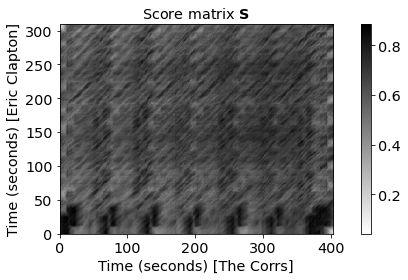

In [102]:
def plot_matrix(X, Fs=1, Fs_F=1, T_coef=None, F_coef=None, xlabel='Time (seconds)', ylabel='Frequency (Hz)',
                xlim=None, ylim=None, clim=None, title='', dpi=72,
                colorbar=True, colorbar_aspect=20.0, cbar_label='', ax=None, figsize=(6, 3), **kwargs):
    """2D raster visualization of a matrix, e.g. a spectrogram or a tempogram.

    Args:
        X: The matrix
        Fs: Sample rate for axis 1 (Default value = 1)
        Fs_F: Sample rate for axis 0 (Default value = 1)
        T_coef: Time coeffients. If None, will be computed, based on Fs. (Default value = None)
        F_coef: Frequency coeffients. If None, will be computed, based on Fs_F. (Default value = None)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Frequency (Hz)')
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        clim: Color limits (Default value = None)
        title: Title for plot (Default value = '')
        dpi: Dots per inch (Default value = 72)
        colorbar: Create a colorbar. (Default value = True)
        colorbar_aspect: Aspect used for colorbar, in case only a single axes is used. (Default value = 20.0)
        cbar_label: Label for colorbar (Default value = '')
        ax: Either (1.) a list of two axes (first used for matrix, second for colorbar), or (2.) a list with a single
            axes (used for matrix), or (3.) None (an axes will be created). (Default value = None)
        figsize: Width, height in inches (Default value = (6, 3))
        **kwargs: Keyword arguments for matplotlib.pyplot.imshow

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = [ax]
    if T_coef is None:
        T_coef = np.arange(X.shape[1]) / Fs
    if F_coef is None:
        F_coef = np.arange(X.shape[0]) / Fs_F

    if 'extent' not in kwargs:
        x_ext1 = (T_coef[1] - T_coef[0]) / 2
        x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
        y_ext1 = (F_coef[1] - F_coef[0]) / 2
        y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
        kwargs['extent'] = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray_r'
    if 'aspect' not in kwargs:
        kwargs['aspect'] = 'auto'
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'interpolation' not in kwargs:
        kwargs['interpolation'] = 'nearest'

    im = ax[0].imshow(X, **kwargs)

    if len(ax) == 2 and colorbar:
        cbar = plt.colorbar(im, cax=ax[1])
        cbar.set_label(cbar_label)
    elif len(ax) == 2 and not colorbar:
        ax[1].set_axis_off()
    elif len(ax) == 1 and colorbar:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, aspect=colorbar_aspect)
        cbar.set_label(cbar_label)

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if xlim is not None:
        ax[0].set_xlim(xlim)
    if ylim is not None:
        ax[0].set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)

    if fig is not None:
        plt.tight_layout()

    return fig, ax, im

figsize=(8, 4)
plot_matrix(S, figsize=figsize, 
                     Fs=Fs_feature, Fs_F=Fs_feature, aspect='equal',
                     title='Score matrix $\mathbf{S}$', 
                     xlabel='Time (seconds) [The Corrs]', 
                     ylabel='Time (seconds) [Eric Clapton]')

plt.tight_layout()